<h1>Payment Profile and BSM Pricing for Plain Vanilla Options</h1>

Required Modules
<ul>
  <li><b>Numpy</b> for function definition</li>
  <li><b>scipy.stats.norm</b> for the Normaldistribution</li> 
  <li><b>PyLab</b> for plotting</li>
  <li><b>Matplotlib</b> for plotting</li>
  <li><b>QuantLib</b> for reverse backtesting</li>
</ul>

In [120]:
%matplotlib inline
import numpy as np 
#from scipy.stats import norm (see below)
import matplotlib
from pylab import *
#from QuantLib import * (see below)

We define a function for the payout; in the simplest model it just depends on the option type (Put or Call) and the Strike $K$. The payout will be plotted whilst varying the underlying $S$. The payout is defined as $$ p_{Call} = max(0, S - K) $$ and $$  p_{Put} = max(K-S, 0) $$

In [126]:
import warnings
warnings.filterwarnings("ignore", category=Warning) #disable a matplot warning

In [209]:
def PayoutProfile(Type, Underlying, Strike):
    x = np.linspace(Underlying-(Underlying*1.2-Underlying), Underlying*1.2, 100)
    if Type=='Call':
        y = np.piecewise(x, [x <= Strike, x > Strike], [0, lambda x: x-Strike])
    elif Type=='Put':
        y = np.piecewise(x, [x <= Strike, x > Strike], [lambda x: Strike-x, 0])
    return x, y

We set up a simple call for illustraton.

In [210]:
Strike=100
Underlying=100
Type='Call'
x, y = PayoutProfile(Type,Underlying,Strike);

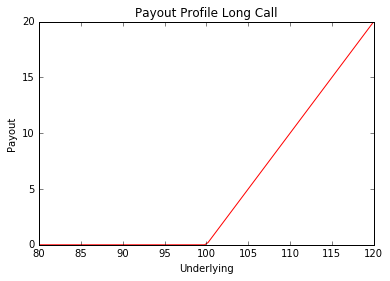

In [211]:
#figure()
plot(x, y, 'r')
xlabel('Underlying')
ylabel('Payout')
title('Payout Profile Long '+ Type)
show()

Now, we can plot the four basics payoff profiles.

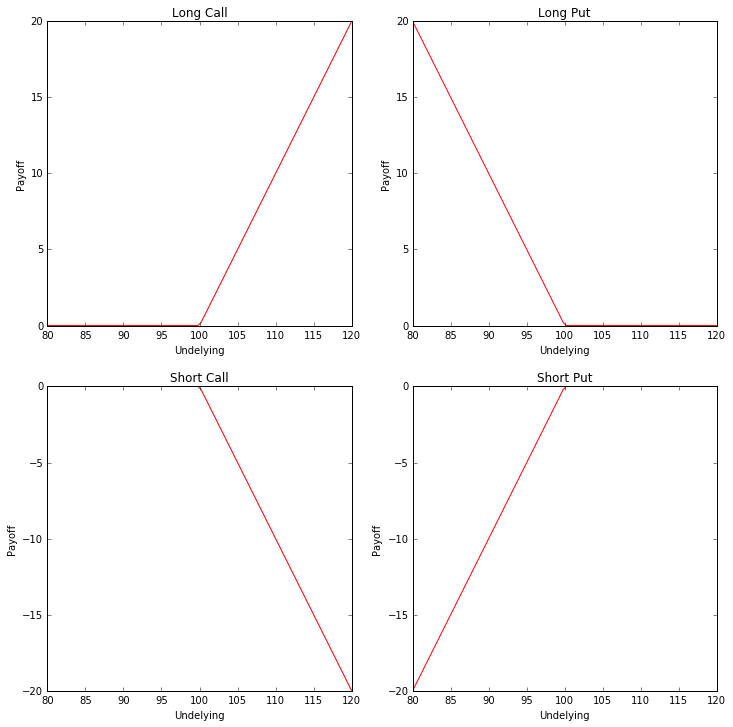

In [130]:
figure, axarr = subplots(2, 2,figsize=(12,12))

x, y = PayoutProfile('Call',100);
axarr[0, 0].set_title('Long Call')
axarr[0, 0].plot(x, y, 'r')
axarr[1, 0].set_title('Short Call')
axarr[1, 0].plot(x, -y, 'r')

x, y = PayoutProfile('Put',100)
axarr[0, 1].set_title('Long Put')
axarr[0, 1].plot(x, y, 'r')
axarr[1, 1].set_title('Short Put')
axarr[1, 1].plot(x, -y, 'r')
for ax in figure.get_axes():
    ax.set_xlabel("Undelying")
    ax.set_ylabel("Payoff")
figure.show()

We define a function for the Black-Scholes-Merton pricing formulas for the Call $$ V_{Call}(S,t)=S\mathcal{N}(d_1)-Ke^{-rt}\mathcal{N}(d_2)$$ and the Put $$ V_{Put}(S,t)=Ke^{-rt}\mathcal{N}(-d_2)-S\mathcal{N}(-d_1)$$ where $$d_1=\frac{ln (\frac{S}{K})+(r-q+\frac{\sigma^2}{2})t}{\sigma\sqrt{t}} $$
and $$ d_2 = d_1-\sigma\sqrt{t}$$
Additionally we have to the specifiy the parameters for the risk free interest rate $r$, the volatility $ \sigma $ and the time to maturity $t$.

In [131]:
from scipy.stats import norm #why must this statement be here?
def BlackScholesMerton(Type, Underlying, Strike, Interest, Volatility, Maturity):
    d_1 = (log(Underlying/Strike)+(Interest+Volatility**2/2)*Maturity) /  (Volatility*sqrt(Maturity))  
    d_2 = d_1 - Volatility * math.sqrt(Maturity)
    if Type=='Call':
        y = Underlying*norm.cdf(d_1) -Strike*e**(-Interest*Maturity)*norm.cdf(d_2)
    elif Type=='Put':
        y = Strike* e**(-Interest*Maturity)*norm.cdf(-d_2) -Underlying*norm.cdf(-d_1)
    return y

We test the formula for a simple example: $S=100, K= 100, r=0.05, \sigma=0.2, t=1$

In [219]:
Underlying=100
Strike=100
Interest=0.05
Volatility=0.2
Maturity=1

y = BlackScholesMerton('Call', Underlying, Strike,Interest, Volatility, Maturity)
print ('Call:' + str(y))
y = BlackScholesMerton('Put', Underlying, Strike,Interest, Volatility, Maturity)
print ('Put:' + str(y))


Call:10.4505835722
Put:5.57352602226


We define a curve (for plotting) and add it the previous plot. Additional assumptions have to be on: $ K=100,r=0.05, \sigma=0.02, t=0.3$ 

In [220]:
Underlying=100
Strike=100
Interest=0.05
Volatility=0.2
Maturity=0.3 # reducing maturity for better visualisation

In [221]:
#plots the curve ~20% around the price of the underlying
def BSMCurve(Type, Underlying, Strike,Interest, Volatility, Maturity):
    x = np.linspace(Underlying-(Underlying*1.2-Underlying), Underlying*1.2, 100)
    y = BlackScholesMerton(Type, x, Strike,Interest, Volatility, Maturity)
    return x, y

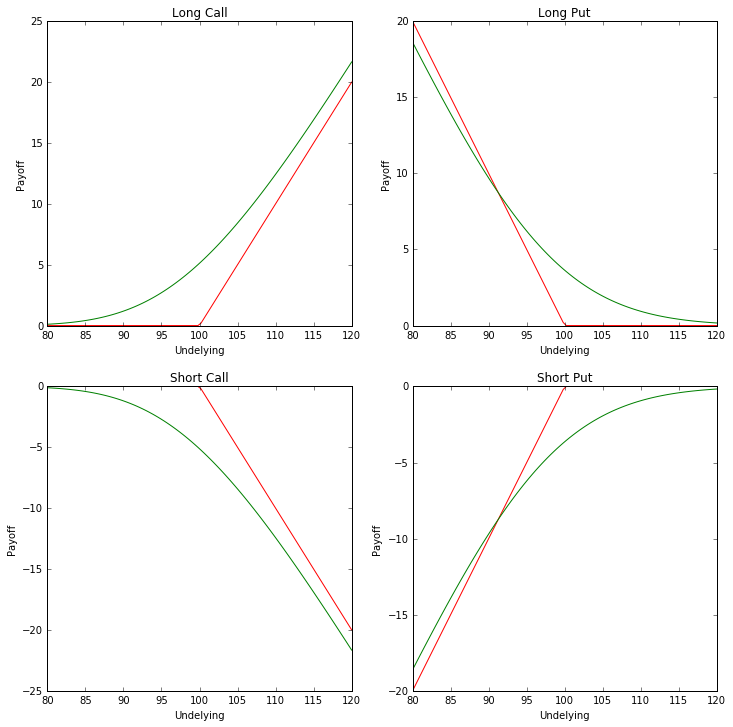

In [222]:
figure, axarr = subplots(2, 2,figsize=(12,12))

x, y = PayoutProfile('Call',Underlying, Strike);
fx, fy =  BSMCurve('Call', Underlying,Strike,Interest, Volatility, Maturity)
axarr[0, 0].set_title('Long Call')
axarr[0, 0].plot(x, y, 'r')
axarr[0, 0].plot(fx, fy, 'g')
axarr[1, 0].set_title('Short Call')
axarr[1, 0].plot(x, -y, 'r')
axarr[1, 0].plot(fx, -fy, 'g')

x, y = PayoutProfile('Put',Underlying, Strike)
fx, fy =  BSMCurve('Put', Underlying,Strike,Interest, Volatility, Maturity)
axarr[0, 1].set_title('Long Put')
axarr[0, 1].plot(x, y, 'r')
axarr[0, 1].plot(fx, fy, 'g')
axarr[1, 1].set_title('Short Put')
axarr[1, 1].plot(x, -y, 'r')
axarr[1, 1].plot(fx, -fy, 'g')
for ax in figure.get_axes():
    ax.set_xlabel("Undelying")
    ax.set_ylabel("Payoff")
figure.show()

We verify the result with QuantLib

In [223]:
from QuantLib import *
today = Date(15,January,2014)
Settings.instance().evaluationDate = today
option1 = EuropeanOption(PlainVanillaPayoff(Option.Call, Strike), 
                        EuropeanExercise(Date(14, January, 2015)))
option2 = EuropeanOption(PlainVanillaPayoff(Option.Put, Strike), 
                        EuropeanExercise(Date(14, January, 2015)))
u = SimpleQuote(Underlying)
r = SimpleQuote(Interest)
sigma = SimpleQuote(Volatility)
riskFreeCurve = FlatForward(0, TARGET(), QuoteHandle(r), Actual360())
volatility = BlackConstantVol(0, TARGET(), QuoteHandle(sigma), Actual360())
process = BlackScholesProcess(QuoteHandle(u), 
                             YieldTermStructureHandle(riskFreeCurve),
                             BlackVolTermStructureHandle(volatility))
engine = AnalyticEuropeanEngine(process)
option1.setPricingEngine(engine) # a little bit too far off.
option2.setPricingEngine(engine) # a little bit too far off.
print ('Call:' + str(option1.NPV()))
print ('Put:' + str(option2.NPV()))

Call:10.521721690242511
Put:5.591832737923376


In [224]:
%quickref